In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

### Data Preparation and Exploration

In [3]:
# Load the dataset
data = pd.read_csv("exchange_rate.csv")

In [5]:
data

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [7]:
# Convert the 'Date' column to datetime format
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
data.set_index('date', inplace=True)
print(data.head())



            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849


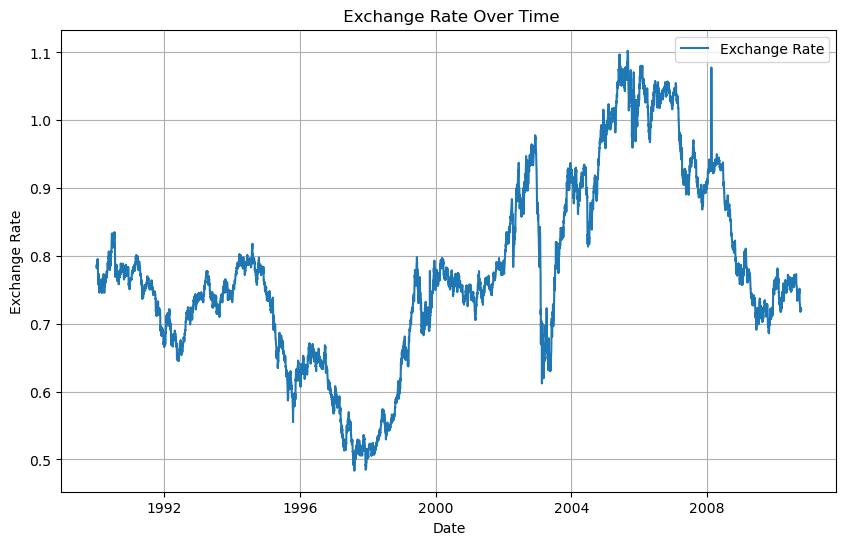

In [11]:
# Plot the time series data (USD to AUD)
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='Exchange Rate')
plt.title(' Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
data


,Ex_rate
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


In [15]:
# Check for missing values
print(data.isnull().sum())
data.fillna(method='ffill', inplace=True)


Ex_rate    0
dtype: int64


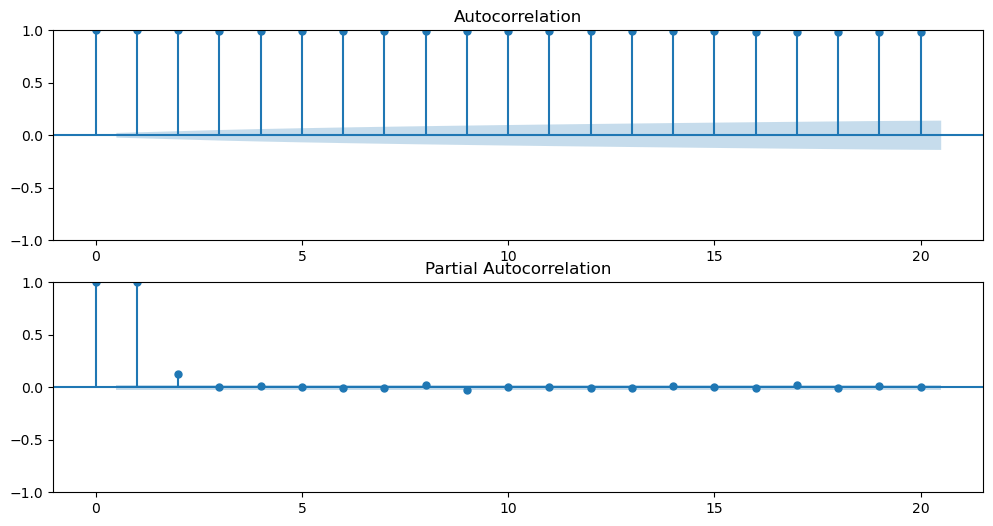

In [18]:
# Plot ACF and PACF to help determine the p, d, q parameters
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data['Ex_rate'], lags=20, ax=plt.gca())
plt.subplot(212)
plot_pacf(data['Ex_rate'], lags=20, ax=plt.gca())
plt.show()

### ARIMA Model

In [21]:
# Fit the ARIMA model
# Set ARIMA parameters (p, d, q) based on the ACF/PACF plots (example: p=1, d=1, q=1)
model = ARIMA(data['Ex_rate'], order=(1, 1, 1)) # Using the correct class
arima_result = model.fit()

# Print summary of the ARIMA model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 04 Oct 2024   AIC                         -56102.322
Time:                        11:05:54   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

In [23]:
# Forecast using ARIMA
forecast = arima_result.predict(start=len(data), end=len(data)+29) # Changed to use predict

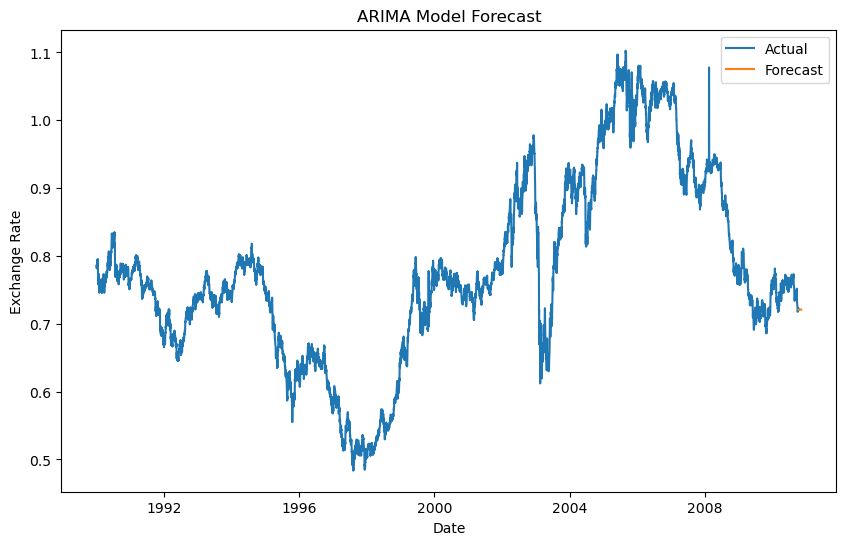

In [25]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Ex_rate'], label='Actual')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='D'), forecast, label='Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### Exponential Smoothing

In [28]:
# Fit an Exponential Smoothing model (Holt's Linear Trend)
model = ExponentialSmoothing(data['Ex_rate'], trend='add')
exp_smoothing_result = model.fit()

# Forecast using Exponential Smoothing
exp_forecast = exp_smoothing_result.forecast(steps=30)



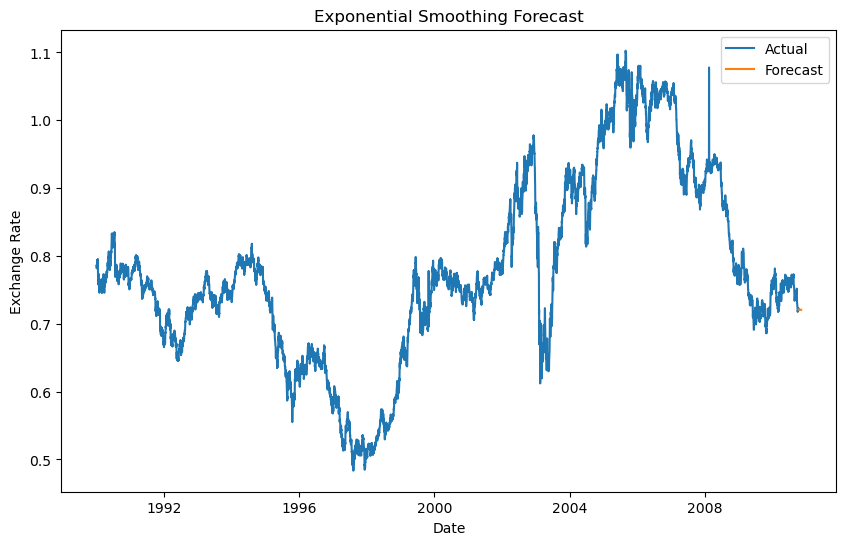

In [30]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Ex_rate'], label='Actual')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='D'), exp_forecast, label='Forecast')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Compute error metrics for ARIMA
mae_arima = mean_absolute_error(data['Ex_rate'][-30:], forecast)
rmse_arima = np.sqrt(mean_squared_error(data['Ex_rate'][-30:], forecast))

# Compute error metrics for Exponential Smoothing
mae_exp = mean_absolute_error(data['Ex_rate'][-30:], exp_forecast)
rmse_exp = np.sqrt(mean_squared_error(data['Ex_rate'][-30:], exp_forecast))

print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}')
print(f'Exponential Smoothing - MAE: {mae_exp}, RMSE: {rmse_exp}')


ARIMA - MAE: 0.012724006489318252, RMSE: 0.016982710912774826
Exponential Smoothing - MAE: 0.012755742909953578, RMSE: 0.01700521798187411


**Grid search ARIMA parameters for a time series**

In [43]:
# grid search ARIMA parameters for a time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [45]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [47]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(data.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


In [49]:
X = data.values
X = X.astype('float32')

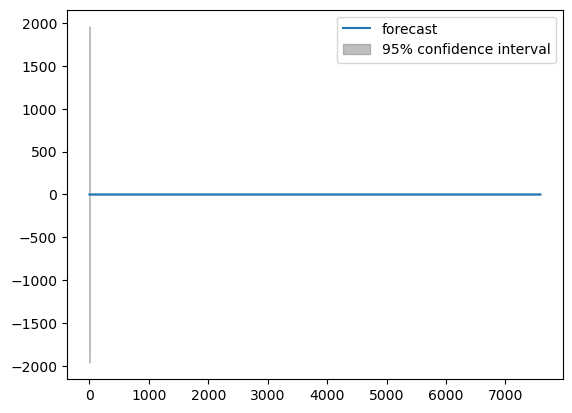

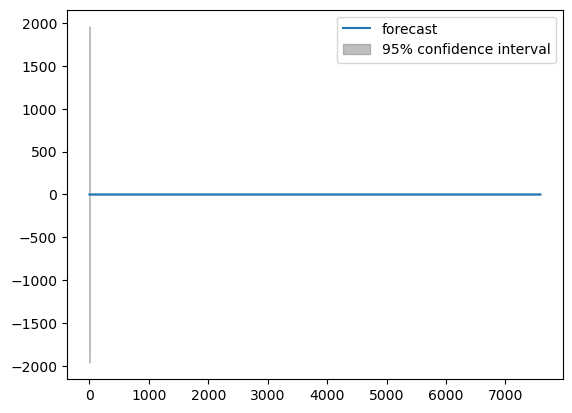

In [51]:
# fit model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict # Import the plot_predict function

model = ARIMA(X, order=(3,1,0)) # Use statsmodels.tsa.arima.model.ARIMA
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
plot_predict(model_fit) # Call the plot_predict function with the model_fit object